In [128]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis, probplot
import pandas as pd
import seaborn as sns
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

plt.rcParams.update({"font.size": 8})


## Task 1

### (a) Data loading

In [129]:
diabetes = load_diabetes()
X_reg = diabetes.data 
y_reg = diabetes.target
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(X_reg, y_reg, test_size=0.3, random_state=42)
df_reg = pd.DataFrame(X_reg, columns=diabetes.feature_names)
df_reg['target'] = y_reg
print(f"Features: {diabetes.feature_names}")


Features: ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']


### (b) Data Cleaning and Statistical analysis

We first examine if any of the values are missing. As can be seen in the cell below, we observe that there is no missing data.

In [130]:
# verify integrity of data
display(df_reg.isnull().any())

age       False
sex       False
bmi       False
bp        False
s1        False
s2        False
s3        False
s4        False
s5        False
s6        False
target    False
dtype: bool

We now take a look at the descriptive statistics of the dataset. We see that the data has already been centered as the mean of all the predictors is zero. The scaling was done based the entire dataset. To avoid data leakage, we will later rescale the data based on the training data alone.

In [131]:
# descriptive statistics
print("Descriptive Statistics - Scaled Full Dataset")
display(df_reg.describe().round(2))

Descriptive Statistics - Scaled Full Dataset


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
count,442.00,442.00,442.00,442.00,442.00,442.00,442.00,442.00,442.00,442.00,442.00
mean,-0.00,0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,0.00,0.00,152.13
std,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,77.09
min,-0.11,-0.04,-0.09,-0.11,-0.13,-0.12,-0.10,-0.08,-0.13,-0.14,25.00
25%,-0.04,-0.04,-0.03,-0.04,-0.03,-0.03,-0.04,-0.04,-0.03,-0.03,87.00
50%,0.01,-0.04,-0.01,-0.01,-0.00,-0.00,-0.01,-0.00,-0.00,-0.00,140.50
75%,0.04,0.05,0.03,0.04,0.03,0.03,0.03,0.03,0.03,0.03,211.50
max,0.11,0.05,0.17,0.13,0.15,0.20,0.18,0.19,0.13,0.14,346.00


We now want to do statistical profiling and understand if our predictors are normaly distributed. We show below the skewness and kurtosis of each predictors. The histogram and Q-Q plot of each predictor is also shown for visualization purposes.

,skewness,kurtosis
age,-0.230596,-0.677199
sex,0.126952,-1.983883
bmi,0.596117,0.080478
bp,0.289671,-0.540333
s1,0.376824,0.216777
s2,0.435109,0.581056
s3,0.796540,0.956896
s4,0.732876,0.425846
s5,0.290763,-0.146396
s6,0.207210,0.220701


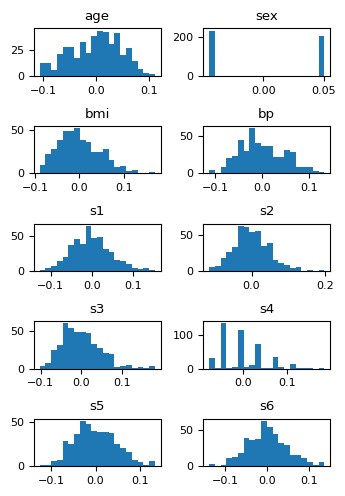

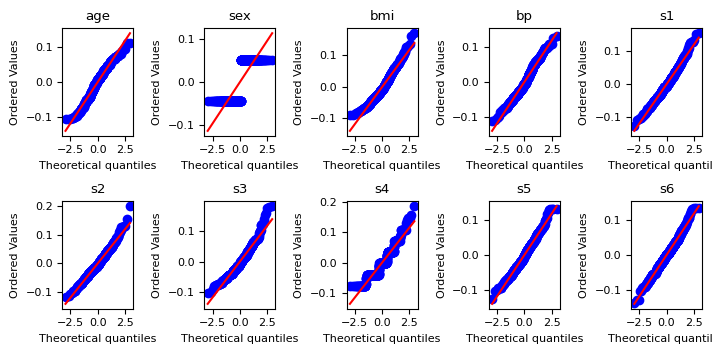

In [132]:
# kurtosis and skewness
display(pd.DataFrame(
    {"skewness": skew(df_reg, axis=0), "kurtosis": kurtosis(df_reg, axis=0)},
    index=df_reg.columns,
))

# histogram of each of the features
fig, axs = plt.subplots(5, 2, figsize=(3.5, 5))
for i, ax in enumerate(axs.ravel()):
    ax.hist(X_reg[:, i], bins=20)
    ax.set_title(diabetes.feature_names[i])

fig.tight_layout()
plt.show()


fig, axs = plt.subplots(2, 5, figsize=(7.16, 7.16/2))

for i, ax in enumerate(axs.ravel()):
    
    # Q-Q plot
    probplot(X_reg[:, i], dist="norm", plot=ax)
    ax.set_title(f"{diabetes.feature_names[i]}")

fig.tight_layout()
plt.show()

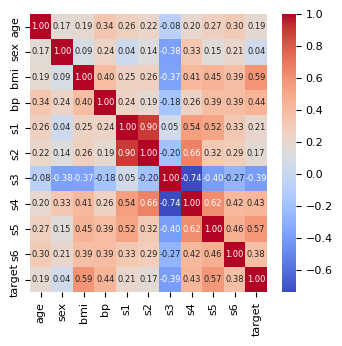

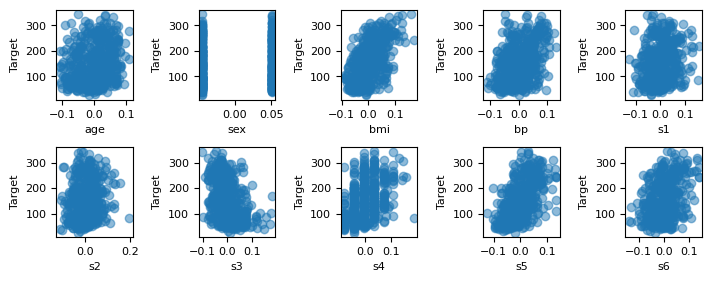

In [133]:
# correlation matrix
fig, ax = plt.subplots(figsize=(3.5, 3.5))
sns.heatmap(df_reg.corr(), annot=True, fmt=".2f", cmap="coolwarm", ax=ax, annot_kws={"size": 6})
fig.tight_layout()
plt.show()

# scatter plot of each feature against the target
fig, axs = plt.subplots(2, 5, figsize=(7.16, 7.16 / 2.5))
for i, ax in enumerate(axs.ravel()):
    ax.scatter(X_reg[:, i], y_reg, alpha=0.5)
    ax.set_xlabel(diabetes.feature_names[i])
    ax.set_ylabel("Target")

fig.tight_layout()
plt.show()


We now want to remove any outliers that could make learning more difficult. To do so we look at the box plot.

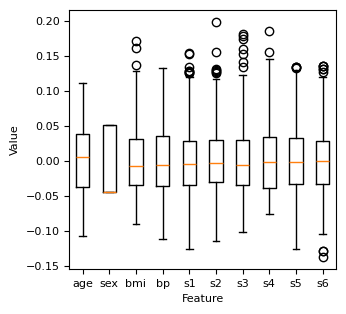

In [145]:
# boxplot of each of the features
plt.figure(figsize=(3.5, 3.5/1.1))
plt.boxplot(X_reg, vert=True, tick_labels=diabetes.feature_names)
plt.xlabel("Feature")
plt.ylabel("Value")
plt.tight_layout()
plt.show()

The boxplot reveals that there are some outliers. We can use the Interquartile Range (IQR) to remove outliers. We make sure to only remove outliers in the training dataset to avoid data leakage. The IQR is also evaluated with respect to the training data.

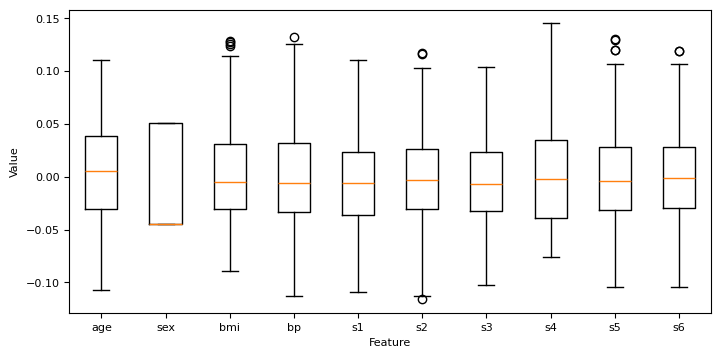

In [135]:
# calculate IQR based on training data
Q1 = np.percentile(X_reg_train, 25, axis=0)
Q3 = np.percentile(X_reg_train, 75, axis=0)
IQR = Q3 - Q1

# define outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# identify outliers (remove sample if ANY feature is outside bounds)
outlier_mask = np.any((X_reg_train < lower_bound) | (X_reg_train > upper_bound), axis=1)

# remove outliers from training data
X_reg_train_clean = X_reg_train[~outlier_mask]
y_reg_train = y_reg_train[~outlier_mask]

# boxplot of each the predictors with outliers removed
plt.figure(figsize=(7.25, 7.25/2))
plt.boxplot(X_reg_train_clean, vert=True, tick_labels=diabetes.feature_names)
plt.xlabel("Feature")
plt.ylabel("Value")
plt.tight_layout()
plt.show()

Finally, we rescale the predictors based on the training data only to avoid data leakage.

In [136]:
scaler_X = StandardScaler()
X_reg_train_scaled = scaler_X.fit_transform(X_reg_train_clean)
X_reg_test_scaled = scaler_X.transform(X_reg_test)

## Task 2

### Lasso Regression

In [146]:
class LassoRegression():
    def __init__(self, learning_rate, iterations, penalty):
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.penalty = penalty
        self.weights = None 
        self.X_train = None  # training data
        self.y_train = None  # training labels
        self.training_loss = None  # training loss over iterations

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        self.weights = np.zeros(X.shape[1] + 1) # add one for bias term
        self.training_loss = [] # reset training loss

        for i in range(self.iterations):
            self.update_weights()
            
            # compute training loss
            error = self.predict(X) - y
            loss = (
                (1 / (2 * X.shape[0])) * np.linalg.norm(error, 2) ** 2 + 
                self.penalty * np.linalg.norm(self.weights[1:], 1)
                ) # exclude bias term from penalty
            self.training_loss.append(loss) # store training loss for given iteration
        return self
    
    def update_weights(self):
        m = self.X_train.shape[0]
        X_aug = np.hstack((np.ones((m, 1)), self.X_train)) # augment with bias term
        weights_gradient = 1 / m * (X_aug.T @ (X_aug @ self.weights - self.y_train))
        self.weights -= self.learning_rate * weights_gradient
        # apply soft-thresholding for L1 penalty (excluding bias term)
        self.weights[1:] = LassoRegression.soft_threshold(
            self.weights[1:], self.learning_rate * self.penalty
            ) 
 
    def predict(self, X):
        if self.weights is None:
            raise ValueError("Model is not trained yet.")
        else:
            return X @ self.weights[1:] + self.weights[0]
        
    @staticmethod
    def soft_threshold(z, alpha):
        return np.sign(z) * np.maximum(np.abs(z) - alpha, 0)

### ElasticNet

In [234]:
class ElasticNetRegression():
    def __init__(self, learning_rate, iterations, penalty, l1_ratio):
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.lambda1 = penalty * l1_ratio
        self.lambda2 = penalty * (1 - l1_ratio)
        self.weights = None 
        self.X_train = None  # training data
        self.y_train = None  # training labels
        self.training_loss = None  # training loss over iterations
  
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        self.weights = np.zeros(X.shape[1] + 1) # add one for bias term
        self.training_loss = []

        for i in range(self.iterations):
            self.update_weights()

            # compute training loss
            error = self.predict(X) - y
            loss = (
                (1 / (2 * X.shape[0])) * np.linalg.norm(error, 2) ** 2 +
                self.lambda1 * np.linalg.norm(self.weights[1:], 1) +
                (self.lambda2 / 2) * np.linalg.norm(self.weights[1:], 2) ** 2
            )
            self.training_loss.append(loss)
            
        return self
    
    def update_weights(self):
        m = self.X_train.shape[0]
        X_aug = np.hstack((np.ones((m, 1)), self.X_train)) # augment with bias term
        weights_gradient = 1 / m * (X_aug.T @ (X_aug @ self.weights - self.y_train)) + self.lambda2 * np.hstack((0, self.weights[1:]))
        self.weights -= self.learning_rate * weights_gradient
        # apply soft-thresholding for L1 penalty (excluding bias term)
        self.weights[1:] = LassoRegression.soft_threshold(
            self.weights[1:], self.learning_rate * self.lambda1
            ) 
 
    def predict(self, X):
        if self.weights is None:
            raise ValueError("Model is not trained yet.")
        else:
            return X @ self.weights[1:] + self.weights[0]
        
    @staticmethod
    def soft_threshold(z, alpha):
        return np.sign(z) * np.maximum(np.abs(z) - alpha, 0)

### Analysis

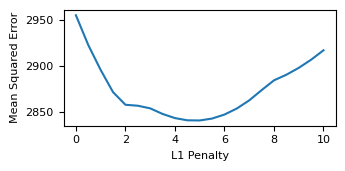

Optimal Lasso penalty: 5.00, MSE: 2840.5836


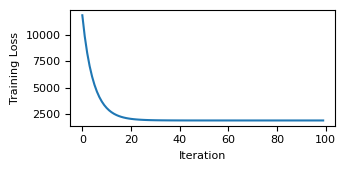

Lasso Regression MSE: 2840.58


In [284]:
# MSE vs L1 penalty figure for lasso regression
mse = []
penalties = np.linspace(0, 10, 21)
for penalty in penalties:
    lasso = LassoRegression(learning_rate=0.1, iterations=100, penalty=penalty).fit(X_reg_train_scaled, y_reg_train)
    ypred = lasso.predict(X_reg_test_scaled)
    mse.append(mean_squared_error(y_reg_test, ypred))
plt.figure(figsize=(3.5, 3.5/2))
plt.plot(penalties, mse)
plt.xlabel("L1 Penalty")
plt.ylabel("Mean Squared Error")
plt.tight_layout()
plt.show()

# best penalty for Lasso based on MSE curve
min_idx = int(np.argmin(mse))
best_penalty = penalties[min_idx]
best_mse = mse[min_idx]
print(f"Optimal Lasso penalty: {best_penalty:.2f}, MSE: {best_mse:.4f}")


# lasso regression
lasso_regression = LassoRegression(learning_rate=0.1, iterations=100, penalty=best_penalty).fit(X_reg_train_scaled, y_reg_train)
ypred_lasso = lasso_regression.predict(X_reg_test_scaled)

plt.figure(figsize=(3.5, 3.5/2))
plt.plot(lasso_regression.training_loss)
plt.xlabel("Iteration")
plt.ylabel("Training Loss")
plt.tight_layout()
plt.show()

mse_lasso = mean_squared_error(y_reg_test, ypred_lasso)
print(f"Lasso Regression MSE: {mse_lasso:.2f}")

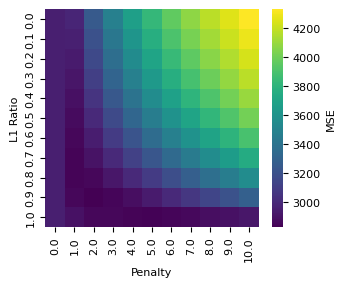

Optimal ElasticNet parameters: penalty: 2.00, l1_ratio: 0.90, MSE: 2828.9304


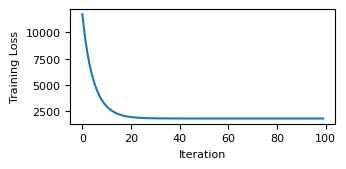

ElasticNet Regression MSE: 2828.93


In [ ]:
# MSE heatmap for ElasticNet regression varying penalty and l1_ratio
penalties = np.linspace(0, 10, 11)
l1_ratios = np.linspace(0, 1, 11)
mse_grid = np.zeros((len(l1_ratios), len(penalties)))

for i, l1_ratio in enumerate(l1_ratios):
    for j, penalty in enumerate(penalties):
        enet = ElasticNetRegression(learning_rate=0.1, iterations=100, penalty=penalty, l1_ratio=l1_ratio).fit(X_reg_train_scaled, y_reg_train)
        ypred = enet.predict(X_reg_test_scaled)
        mse_grid[i, j] = mean_squared_error(y_reg_test, ypred)

plt.figure(figsize=(3.5, 3.5/1.2))
sns.heatmap(
    mse_grid,
    xticklabels=penalties.astype(int),
    yticklabels=(l1_ratios * 10).astype(int),
    cmap="viridis",
    cbar_kws={"label": "MSE"},
)
plt.xlabel("Penalty")
plt.ylabel("L1 Ratio (x10)")
plt.tight_layout()
plt.show()

# best penalty and l1_ratio pair based on MSE grid
min_idx = np.unravel_index(np.argmin(mse_grid), mse_grid.shape)
best_l1_ratio = l1_ratios[min_idx[0]]
best_penalty = penalties[min_idx[1]]
best_mse = mse_grid[min_idx]
print(f"Optimal ElasticNet parameters: penalty: {best_penalty:.2f}, l1_ratio: {best_l1_ratio:.2f}, MSE: {best_mse:.4f}")

# enet regression
enet_regression = ElasticNetRegression(learning_rate=0.1, iterations=100, penalty=best_penalty, l1_ratio=best_l1_ratio).fit(X_reg_train_scaled, y_reg_train)
ypred_enet = enet_regression.predict(X_reg_test_scaled)

plt.figure(figsize=(3.5, 3.5/2))
plt.plot(enet_regression.training_loss)
plt.xlabel("Iteration")
plt.ylabel("Training Loss")
plt.tight_layout()
plt.show()

mse_enet = mean_squared_error(y_reg_test, ypred_enet)
print(f"ElasticNet Regression MSE: {mse_enet:.2f}")

In [153]:
# linear regression from sklearn
linear_regression = LinearRegression().fit(X_reg_train_scaled, y_reg_train)
ypred_lr = linear_regression.predict(X_reg_test_scaled)
mse_lr = mean_squared_error(y_reg_test, ypred_lr)
print(f"Linear Regression MSE: {mse_lr:.2f}")

Linear Regression MSE: 2962.44
